**imports**

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
boston_dataset = load_boston()
data = pd.DataFrame(data=boston_dataset.data, columns=boston_dataset.feature_names)
data['PRICE'] = boston_dataset.target

In [6]:
prices = data['PRICE']
features = data.drop('PRICE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=10)
len(X_train)/len(features)

0.7984189723320159

In [7]:
X_incl_const = sm.add_constant(X_train)

## Testing for Multicollinearity

$ TAX = \alpha _0 + \alpha _1 RM + \alpha _2 NOX + ... + \alpha _{12}LSTAT $

$ VIF _{TAX} = \frac{1}/{(1 - R _{TAX} ^ 2)} $

In [8]:
len(X_incl_const.columns)
X_incl_const.shape[1]

14

In [9]:
for i in range(X_incl_const.shape[1]):
    print(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))

597.5487126763895
1.7145250443932485
2.3328224265597584
3.943448822674636
1.0788133385000576
4.410320817897634
1.8404053075678568
3.3267660823099408
4.222923410477865
7.314299817005058
8.508856493040817
1.839911632651406
1.3386713255364715
2.812544292793034


In [10]:
vif = []
for i in range(X_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
print(vif)

[597.5487126763895, 1.7145250443932485, 2.3328224265597584, 3.943448822674636, 1.0788133385000576, 4.410320817897634, 1.8404053075678568, 3.3267660823099408, 4.222923410477865, 7.314299817005058, 8.508856493040817, 1.839911632651406, 1.3386713255364715, 2.812544292793034]


In [11]:
pd.DataFrame({'coef_name': X_incl_const.columns, 'vif': np.around(vif, 2)})

,coef_name,vif
0,const,597.55
1,CRIM,1.71
2,ZN,2.33
3,INDUS,3.94
4,CHAS,1.08
5,NOX,4.41
6,RM,1.84
7,AGE,3.33
8,DIS,4.22
9,RAD,7.31


### Model Simplification and BIC

In [12]:
# Original model with log prices and all features

X_incl_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

reduced_coef = pd.DataFrame({'coef': results.params, 'p-values': round(results.pvalues, 3)})

print('BIC is: ', results.bic)
print('r-squared is', results.rsquared)

BIC is:  2424.9546968561976
r-squared is 0.750121534530608


In [13]:
# Original model with log prices and all features

X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['INDUS', 'AGE'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

coef_minus_indus = pd.DataFrame({'coef': results.params, 'p-values': round(results.pvalues, 3)})

print('BIC is: ', results.bic)
print('r-squared is', results.rsquared)

BIC is:  2414.269332783494
r-squared is 0.7493053373352907


In [15]:
frames = [coef_minus_indus, reduced_coef]
pd.concat(frames, axis=1)

,coef,p-values,coef,p-values
const,36.115550,0.000,36.533051,0.000
CRIM,-0.127574,0.000,-0.128181,0.000
ZN,0.061404,0.000,0.063198,0.000
CHAS,2.042927,0.026,1.974515,0.033
NOX,-15.177678,0.000,-16.271989,0.000
RM,3.207983,0.000,3.108456,0.000
DIS,-1.546495,0.000,-1.483014,0.000
RAD,0.300285,0.000,0.303988,0.000
TAX,-0.012138,0.000,-0.012082,0.001
PTRATIO,-0.809111,0.000,-0.820306,0.000


### Residuals & Residual Plots

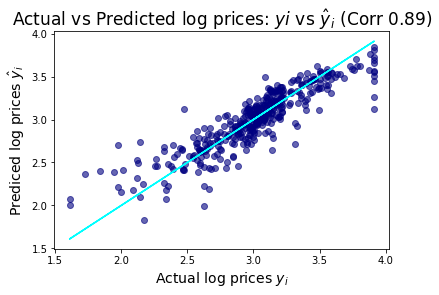

NameError: name 'e' is not defined

In [16]:
# Modified model: transformed (using log prices) & simplified (dropping two features)
prices = np.log(data['PRICE']) # Use log prices
features = data.drop(['PRICE', 'INDUS', 'AGE'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=10)

# Using Statsmodel
X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()

# Residuals
residuals = y_train - results.fittedvalues
residuals

corr = round(y_train.corr(results.fittedvalues), 2)
plt.scatter(x=y_train, y=results.fittedvalues, c='navy', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')

plt.xlabel('Actual log prices $y _i$', fontsize=14)
plt.ylabel('Prediced log prices $ \hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted log prices: $y i$ vs $ \hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

# Residuals vs Predicted values

plt.scatter(x=np.e**y_train, y=e**results.fittedvalues, c='navy', alpha=0.6)
plt.plot(np.e**y_train, np.e**y_train, color='cyan')

plt.xlabel('Actual log prices $y _i$', fontsize=14)
plt.ylabel('Prediced log prices $ \hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted log prices: $y i$ vs $ \hat y_i$ (Corr {corr})', fontsize=17)